<div style="display: block; text-align: center">
    <h2 style='color: gold'><font color='royalblue'>Quantum walk</font> resource comparison - <font color='indigo'>Increment/Decrement approach</font> vs. <font color='blueviolet'>Nearest Neighbor approach</font></h2>
</div>

> - In the increment/decrement approach, we required two components for shifting the walker after the toss. Say when the coin toss result is HEAD, we need to move the walker right i.e.: increment its current position state $(\ket{x}=\ket{x+1})$ and move left i.e.: decrement the current position state $(\ket{x}=\ket{x-1})$ otherwise. Note that in this case, when decrementing, in case of negative numbers, the circuit outputs 2's complement numbers.
> - In contrast, nearest neighbor approach requires one.
> - In case of increment/decrement, we were repeating those those two components after each toss. However, in nearest neighbor approach, that one component is different for when the walker is on a even position state and when the walker is on an odd position state.

In [1]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, BasicAer, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider
import math as m

## Increment & Decrement components

> The two functions written below, ```get_increment()``` and ```get_decrement()``` are used to prepare the circuit for increment and decrement respectively. Later I have written another function ```prepare_incdec(N)```. That function is the main driver function for the naive increment decrement quantum walk implementation. Calling ```prepare_incdec(N)``` with any value for $N$ (int: number of qubits) will return the quantum circuit for increment decrement quantum walk. These two functions are used as helpers in that function.

In [2]:
def get_increment(qc):
    """
    This function is to prepare the quantum circuit for increment. The changes are not made directly to the argument.
    Parameters:
        qc (QuantumCircuit): The QuantumCircuit object from qiskit where the increment logic is to be implemented.
    Returns:
        QuantumCircuit: A QuantumCircuit object with the increment logic added to it
    """
    qc_copy = qc.copy()
    qr = qc_copy.qubits
    N = len(qr)-1    # because N-1 qubits are used to represent position space and 1 qubit for the coin 
    coin = qr[len(qr)-1]
    
    for i in range(N-1, -1, -1):
        ctrls = []
        for j in range(i): ctrls.append(j)
        ctrls.append(coin)
        qc_copy.mcx(ctrls, qr[i])
        
    return qc_copy

def get_decrement(qc):
    """
    This function is to prepare the quantum circuit for decrement. The changes are not made directly to the argument.
    Parameters:
        qc (QuantumCircuit): The QuantumCircuit object from qiskit where the decrement logic is to be implemented.
    Returns:
        QuantumCircuit: A QuantumCircuit object with the decrement logic added to it
    """
    qc_copy = qc.copy()
    qr = qc_copy.qubits
    N = len(qr)-1    # because N-1 qubits are used to represent position space and 1 qubit for the coin 
    coin = qr[len(qr)-1]
    
    for i in range(0, N):
        ctrls = []
        for j in range(i): ctrls.append(j)
        ctrls.append(coin)
        qc_copy.mcx(ctrls, qr[i])
        
    return qc_copy
    

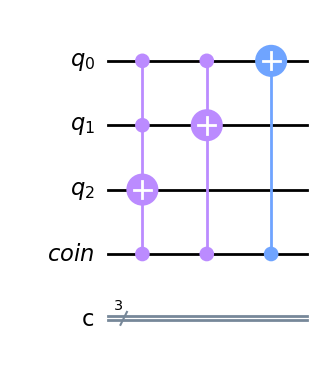

In [3]:
N = 3
qc = QuantumCircuit(QuantumRegister(N, 'q'), QuantumRegister(1, 'coin'), ClassicalRegister(N, 'c'))
increment_logic = get_increment(qc)
increment_logic.draw('mpl', style='clifford')

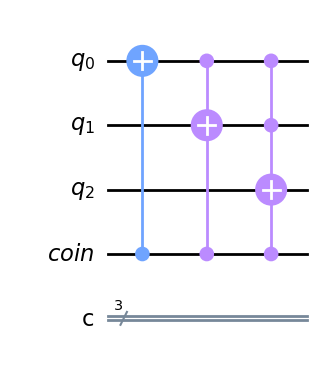

In [4]:
decrement_logic = get_decrement(qc)
decrement_logic.draw('mpl', style='clifford')

## Increment/Decrement (naive) Quantum Walk

> And here comes the main driver function for the naive quantum walk implementation as I mentioned earlier.

In [5]:
def prepare_incdec(N, verbose=False):
    coin = QuantumRegister(1, 'coin')
    nqw = QuantumCircuit(QuantumRegister(N, 'q'), coin, ClassicalRegister(N, 'c'))

    if verbose:
        state_label = '0'
        for i in range(N): state_label += '0'
        print(f'Initial state: {state_label}')
        v = Statevector.from_label(state_label)
        new = {}
    
    # ((2**N)-1)//2
    for i in range(((2**N)-1)//2):
        nqw.h(coin)    # tossing the coin
        nqw = get_increment(nqw)
        # nqw.barrier()  # done incrementing on coin toss
        nqw.x(coin)
        nqw = get_decrement(nqw)
        nqw.x(coin)
        if verbose: nqw.barrier()  # done incrementing on coin toss

        if verbose:
            # this below section is to get how many steps I get after ith toss
            # this section has nothing to do with the actual walk rather it is
            # to verify the implementation's correctness ---------------------
            d = {}
            v = v.reset()
            v = v.evolve(nqw)
            x = v.to_dict()
            c = 0
            for key, value in x.items():
                if abs(value) > 1e-10:
                    d[key[1:]] = value
                    if key[1:] not in new.keys():
                        c += 1
                        new[key[1:]] = c
                        
            print(f'After {i+1} toss(es): {len(d)} states and {c} new states')
            # ----------------------------------------------------------------
    return nqw

Initial state: 00000
After 1 toss(es): 2 states and 2 new states
After 2 toss(es): 3 states and 3 new states
After 3 toss(es): 4 states and 2 new states
After 4 toss(es): 5 states and 2 new states
After 5 toss(es): 6 states and 2 new states
After 6 toss(es): 7 states and 2 new states
After 7 toss(es): 8 states and 2 new states


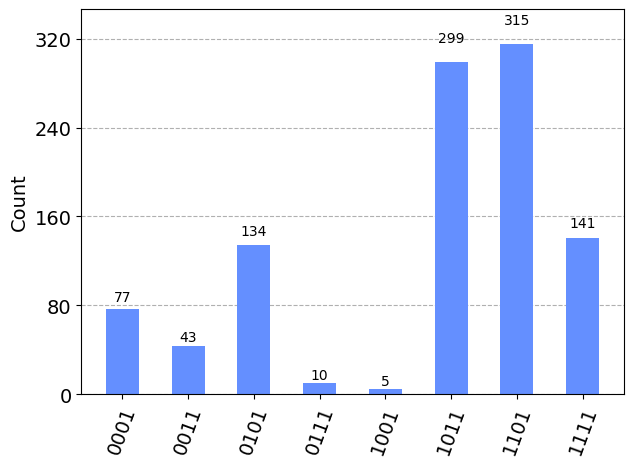

In [6]:
N = 4
nqw = prepare_incdec(N, verbose=True)
# nqw.draw('mpl', style='clifford')
nqw.measure([i for i in range(N)], [i for i in range(N)])
backend = BasicAer.get_backend('qasm_simulator')
circuit_compiled = transpile(nqw, backend)
simulator = backend.run(circuit_compiled, shots=1024)
result = simulator.result()
counts = result.get_counts(circuit_compiled)
plot_histogram(counts)

## Nearest neighbor components

> The two functions written below, ```from_even()``` and ```from_odd()``` are used to shift the walker from even position state and odd position state after coin toss. The plan is same as in the previous case. I have a main driver function later named ```prepare_NN(N)``` which uses these two as helper.

In [7]:
def from_even(qc):
    qc_copy = qc.copy()
    qr = qc_copy.qubits
    N = len(qr)-1
    coin = qr[len(qr)-1]
    
    # qc_copy.h(coin)
    qc_copy.x(qr[0])
    for i in range(N-2, 0, -1):
        ctrls = []
        for j in range(1, i): ctrls.append(j)
        ctrls.append(coin)
        qc_copy.mcx(ctrls, qr[i])
    ctrls = []
    for i in range(1, N-1): ctrls.append(qr[i])
    ctrls.append(coin)
    qc_copy.mcx(ctrls, qr[N-1])
    return qc_copy

def from_odd(qc):
    qc_copy = qc.copy()
    qr = qc_copy.qubits
    N = len(qr)-1
    coin = qr[len(qr)-1]
    
    # qc_copy.h(coin)
    # qc_copy.x(coin)
    qc_copy.x(qr[0])

    ctrls = []
    for i in range(1, N-1): ctrls.append(qr[i])
    ctrls.append(coin)
    qc_copy.mcx(ctrls, qr[N-1])
    for i in range(1, N-1):
        ctrls = []
        for j in range(1, i): ctrls.append(j)
        ctrls.append(coin)
        qc_copy.mcx(ctrls, qr[i])
    # qc_copy.x(coin)
    return qc_copy

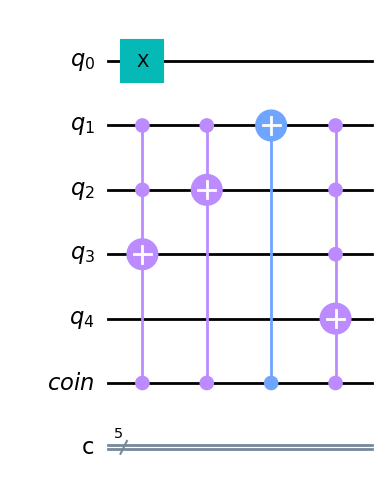

In [8]:
N = 5
qc = QuantumCircuit(QuantumRegister(N, 'q'), QuantumRegister(1, 'coin'), ClassicalRegister(N, 'c'))
even_logic = from_even(qc)
even_logic.draw('mpl', style='clifford')

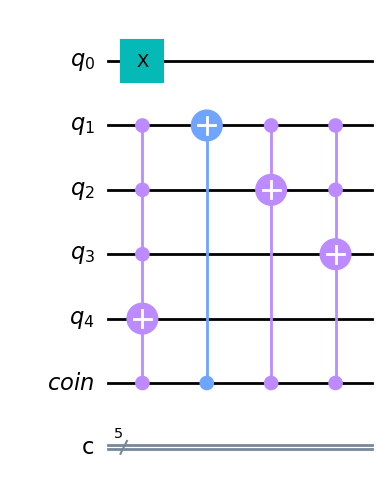

In [9]:
odd_logic = from_odd(qc)
odd_logic.draw('mpl', style='clifford')

## Nearest neighbor quantum walk

> Here comes the main driver function for generalized nearest neighbor quantum walk implementation.

In [10]:
def prepare_NN(N, verbose=False):
    coin = QuantumRegister(1, 'coin')
    nnqw = QuantumCircuit(QuantumRegister(N, 'q'), coin, ClassicalRegister(N, 'c'))

    if verbose:
        state_label = '0'
        for i in range(N): state_label += '0'
        print(f" Intial state: {state_label}")
        v = Statevector.from_label(state_label)
        new = {}
    
    # ((2**N)-1)//2
    for i in range(((2**N)-1)//2):
        if i%2 == 0:
            nnqw.h(coin)    # tossing the coin
            nnqw = from_even(nnqw)
            if verbose: nnqw.barrier()
        else:
            nnqw.h(coin)    # tossing the coin
            nnqw.x(coin)
            nnqw = from_odd(nnqw)
            nnqw.x(coin)
            if verbose: nnqw.barrier()

        if verbose:
            # this below section is to get how many steps I get after ith toss
            # this section has nothing to do with the actual walk rather it is
            # to verify the implementation's correctness ---------------------
            d = {}
            v = v.reset()
            v = v.evolve(nnqw)
            x = v.to_dict()
            c = 0
            for key, value in x.items():
                if abs(value) > 1e-10:
                    d[key[1:]] = value
                    if key[1:] not in new.keys():
                        c += 1
                        new[key[1:]] = c
                        
            print(f'After {i+1} toss(es): {len(d)} states and {c} new states')
            # ----------------------------------------------------------------
    return nnqw

 Intial state: 00000
After 1 toss(es): 2 states and 2 new states
After 2 toss(es): 3 states and 3 new states
After 3 toss(es): 4 states and 2 new states
After 4 toss(es): 5 states and 2 new states
After 5 toss(es): 6 states and 2 new states
After 6 toss(es): 7 states and 2 new states
After 7 toss(es): 8 states and 2 new states


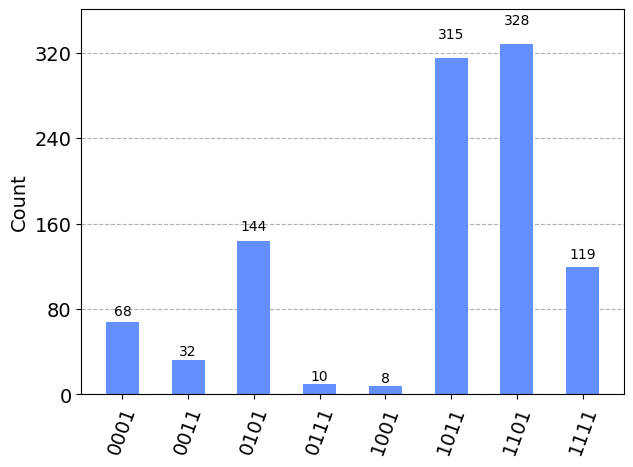

In [24]:
N = 4
nnqw = prepare_NN(N, verbose=True)
# nnqw.draw('mpl', style='clifford')
nnqw.measure([i for i in range(N)], [i for i in range(N)])
backend = BasicAer.get_backend('qasm_simulator')
circuit_compiled = transpile(nqw, backend)
simulator = backend.run(circuit_compiled, shots=1024)
result = simulator.result()
counts = result.get_counts(circuit_compiled)
plot_histogram(counts)

## Naive implementation vs. Nearest Neighbor - Gate depth analysis

- ### In case you are using a backend for the first time
> In order to get backend service, you need to have a IBMQ account. It is free, so go create an account and from the dashboard, copy your API token. Now, this below two lines of code must be run once before you can use any backend. It basically saves the API token locally so that later the ```IBMProvider()``` can use it. In the place of ```My_API_TOKEN```, paste your own API token.
> ```python
> from qiskit_ibm_provider import IBMProvider
> IBMProvider.save_account(token='MY_API_TOKEN')
> ```

In [12]:
provider = IBMProvider()   # this thing requires that unique API token to be saved locally

In [13]:
# display current supported backends
print(provider.backends())
# get IBM's simulator backend
backend = provider.get_backend('ibmq_qasm_simulator')

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>]


In [46]:
X, y = [[], []], [[], []]
transpileds = [[], []]
for i in range(3, 7):
    N = i
    transpiled_naive = transpile(prepare_incdec(N), backend, optimization_level=2)
    transpiled_NN = transpile(prepare_NN(N), backend, optimization_level=2)
    transpileds[0].append(transpiled_naive)
    transpileds[1].append(transpiled_NN)
    X[0].append(N)
    X[1].append(N)
    y[0].append(transpiled_naive.depth())
    y[1].append(transpiled_NN.depth())
    print(f'Done for N={N}')

Done for N=3
Done for N=4
Done for N=5
Done for N=6


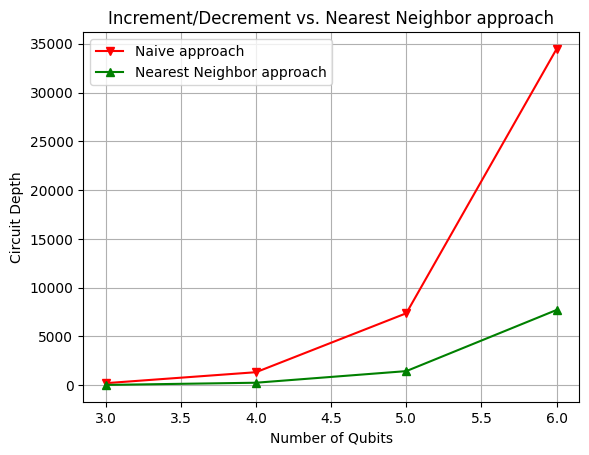

In [47]:
plt.plot(X[0], y[0], c='red', marker='v')
plt.plot(X[1], y[1], c='green', marker='^')
plt.title("Increment/Decrement vs. Nearest Neighbor approach")
plt.xlabel('Number of Qubits')
plt.ylabel('Circuit Depth')
plt.grid()
plt.legend(['Naive approach', 'Nearest Neighbor approach'])
plt.show()

## Naive implementation vs. Nearest Neighbor - Gate count analysis (incomplete)

OrderedDict({'cx': 126, 'p': 76, 'u1': 38, 'u2': 7, 'h': 4, 'x': 4})


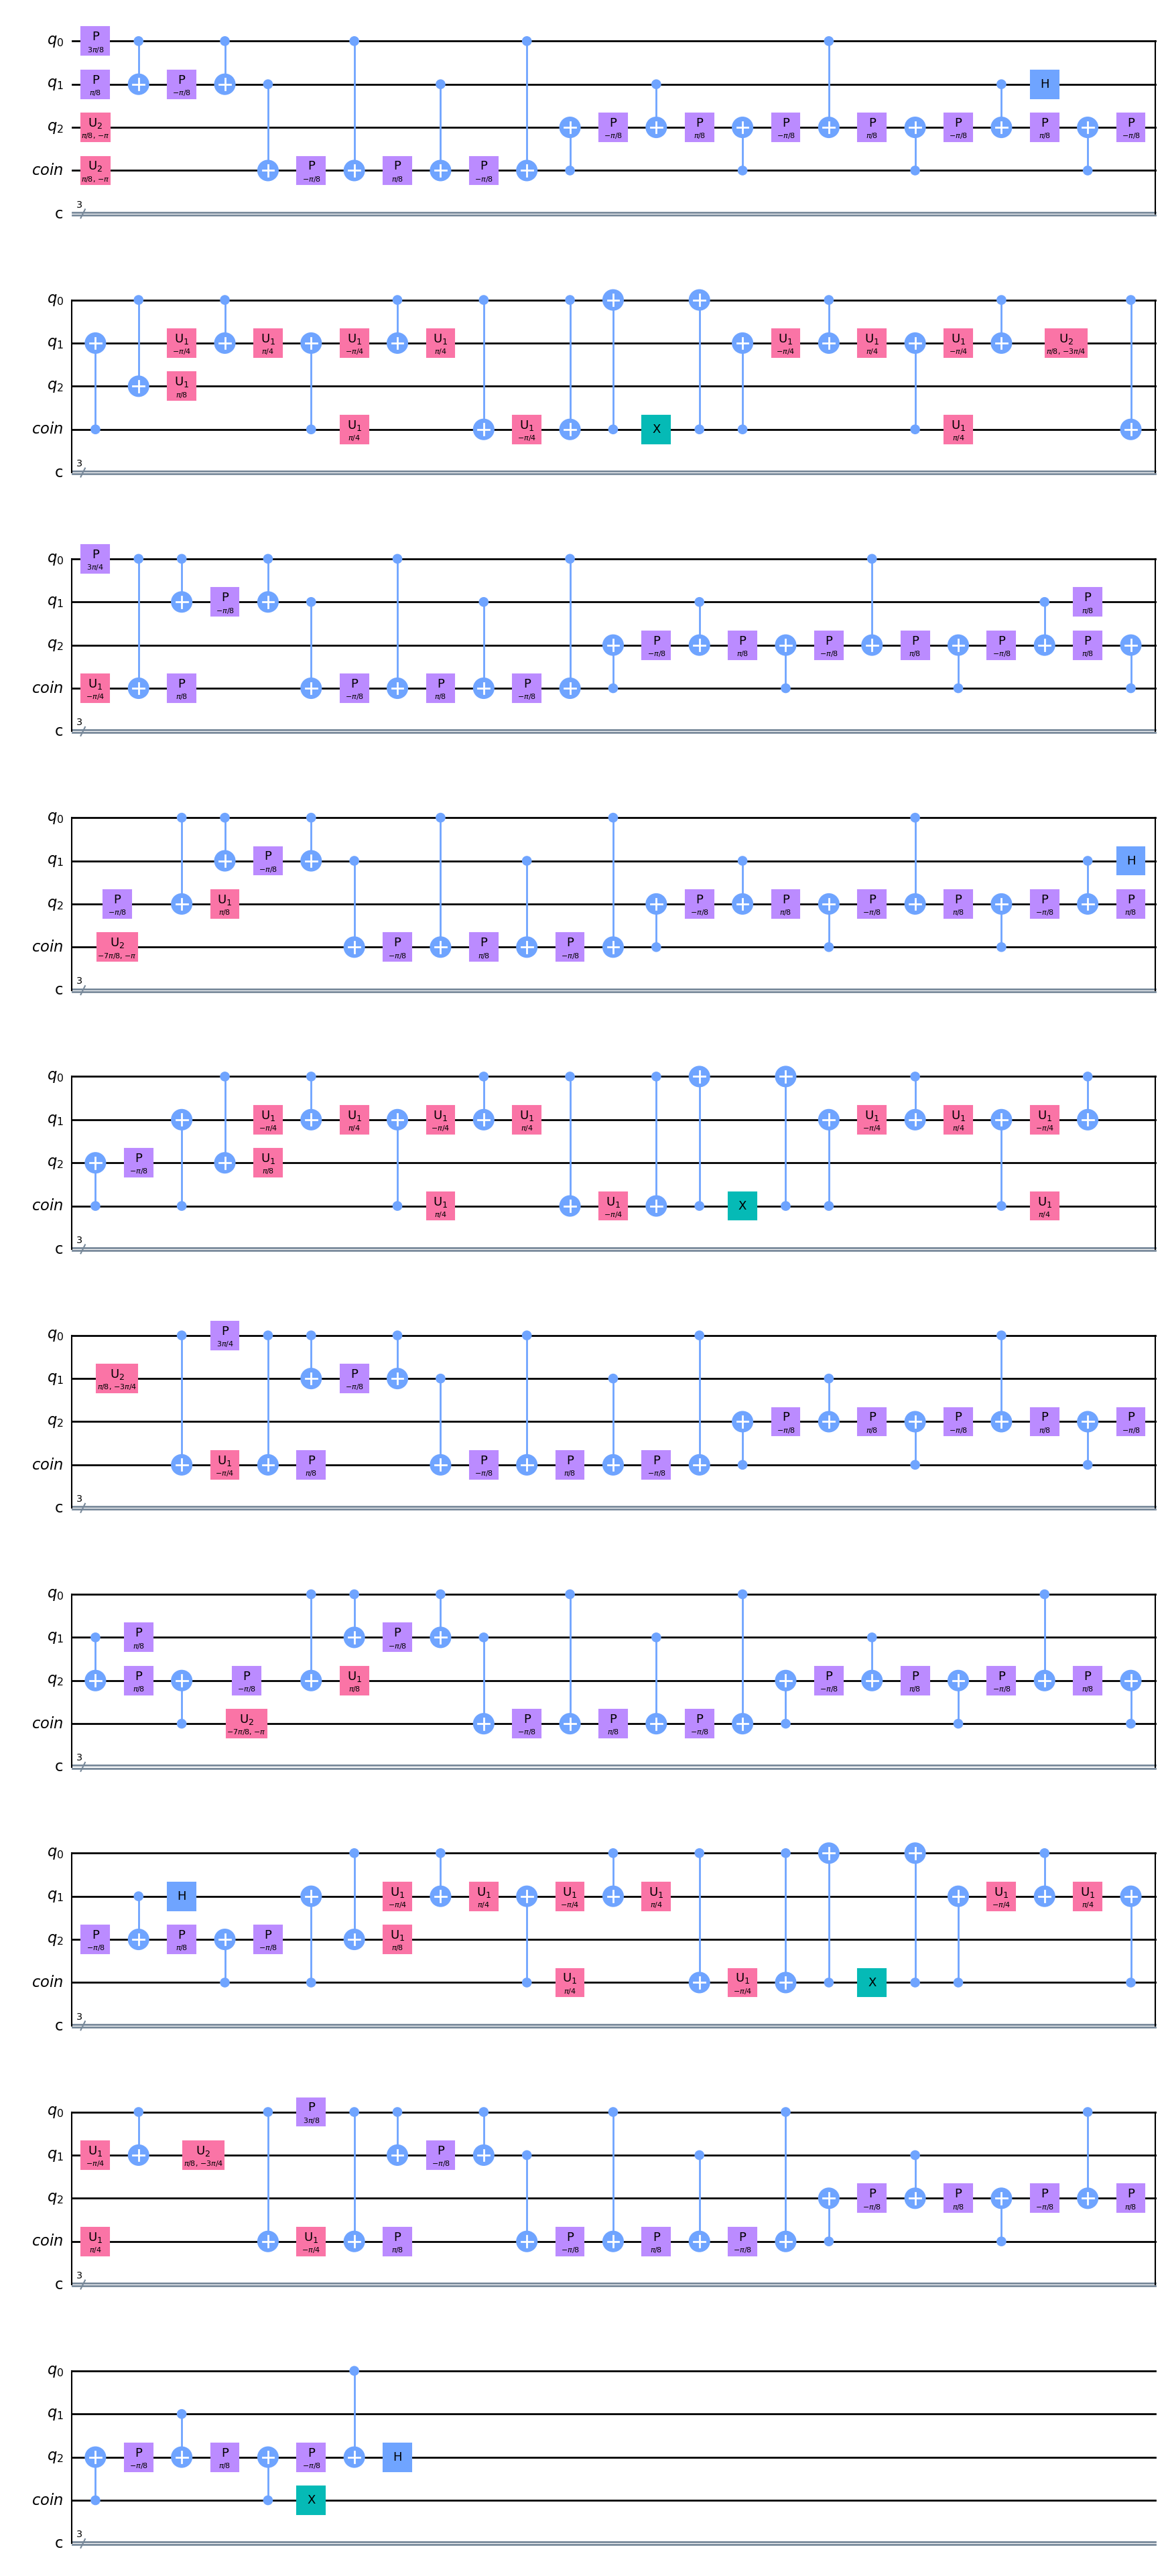

In [58]:
print(transpileds[0][0].count_ops())
transpileds[0][0].draw('mpl')